In [3]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch
import sklearn
import sklearn.cluster
from torch_geometric.nn import TransformerConv  # Import the Graph Transformer layer
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GATConv
class GCN_NET(torch.nn.Module):
    def __init__(self, nhid, nout, dropout):
        super().__init__()
        self.conv1 = GCNConv(data.num_node_features, nhid)
        self.conv2 = GCNConv(nhid,nout)
        #self.conv1 = TransformerConv(data.num_node_features, nhid, heads=4)  # You can adjust the number of heads
        #self.conv2 = TransformerConv(nhid * 4, nout)  # Output feat
        #self.conv1 = SAGEConv(data.num_node_features, nhid)
        #self.conv2 = SAGEConv(nhid, nout)
        #self.conv1 = GATConv(data.num_node_features,  nhid)  # 多头注意力机制
        #self.conv2 = GATConv( nhid , nout)  # 最后一层注意力机制，使用单个头
        self.dropout = dropout
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x,self.dropout , training=self.training)
        x = self.conv2(x, edge_index)
        return x
def cluster(data, k, temp, num_iter, init = None, cluster_temp=5):
    '''
    pytorch (differentiable) implementation of soft k-means clustering.
    '''
    #normalize x so it lies on the unit sphere
    data = torch.diag(1./torch.norm(data, p=2, dim=1)) @ data
    #use kmeans++ initialization if nothing is provided
    if init is None:
        data_np = data.detach().numpy()
        norm = (data_np**2).sum(axis=1)
        init = sklearn.cluster.k_means_._k_init(data_np, k, norm, sklearn.utils.check_random_state(None))
        init = torch.tensor(init, requires_grad=True)
        if num_iter == 0: return init
    mu = init
    n = data.shape[0]
    d = data.shape[1]
#    data = torch.diag(1./torch.norm(data, dim=1, p=2))@data
    for t in range(num_iter):
        #get distances between all data points and cluster centers
#        dist = torch.cosine_similarity(data[:, None].expand(n, k, d).reshape((-1, d)), mu[None].expand(n, k, d).reshape((-1, d))).reshape((n, k))
        dist = data @ mu.t()
        #cluster responsibilities via softmax
        r = torch.softmax(cluster_temp*dist, 1)
        #total responsibility of each cluster
        cluster_r = r.sum(dim=0)
        #mean of points in each cluster weighted by responsibility
        cluster_mean = (r.t().unsqueeze(1) @ data.expand(k, *data.shape)).squeeze(1)
        #update cluster means
        new_mu = torch.diag(1/cluster_r) @ cluster_mean
        mu = new_mu
    dist = data @ mu.t()
    r = torch.softmax(cluster_temp*dist, 1)
    return mu, r, dist

class GCNClusterNet(torch.nn.Module):
    def __init__(self, nfeat, nhid, nout, dropout, K, cluster_temp):
        super(GCNClusterNet, self).__init__()
        self.GCN_NET = GCN_NET(nhid, nout, dropout)
        self.distmult = torch.nn.Parameter(torch.rand(nout))
        self.sigmoid = torch.nn.Sigmoid()
        self.K = K
        self.cluster_temp = cluster_temp
        self.init = torch.rand(self.K, nout)

    def forward(self,x,adj, num_iter=1):
    	#这里的x，adj没有用，为了方便对比本人把它们作为参数加了进来
        embeds = self.GCN_NET(data)
        mu_init, _, _ = cluster(embeds, self.K, 1, num_iter, cluster_temp=self.cluster_temp, init=self.init)
        mu, r, dist = cluster(embeds, self.K, 1, 1, cluster_temp=self.cluster_temp, init=mu_init.detach().clone())
        return mu, r, embeds, dist

In [4]:
def make_modularity_matrix(adj):
    adj = adj * (torch.ones(adj.shape[0], adj.shape[0]) - torch.eye(adj.shape[0]))
    degrees = adj.sum(axis=0).unsqueeze(1)
    mod = adj - degrees @ degrees.t() / adj.sum()
    return mod


def loss_modularity(r, bin_adj, mod):
    bin_adj_nodiag = bin_adj * (torch.ones(bin_adj.shape[0], bin_adj.shape[0]) - torch.eye(bin_adj.shape[0]))
    return (1. / bin_adj_nodiag.sum()) * (r.t() @ mod @ r).trace()


In [5]:
from torch_geometric.datasets import Planetoid, TUDataset
from torch_geometric.utils import to_dense_adj, to_scipy_sparse_matrix, from_scipy_sparse_matrix
import scipy.sparse as sp
import numpy as np
dataset = TUDataset(root='../tmp/Proteins', name='PROTEINS')
print(dataset)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[1].to(device)
print(data)
##获得数据集的data
# 将 edge_index 转换为稠密的邻接矩阵
adj = to_dense_adj(data.edge_index)[0]

def normalize(mx):
    rowsum = np.array(mx.sum(1))  # 矩阵行求和
    r_inv = np.power(rowsum, -1).flatten()  # 每行和的-1次方
    r_inv[np.isinf(r_inv)] = 0.  # 如果是inf，转换为0
    r_mat_inv = sp.diags(r_inv)  # 转换为对角阵
    mx = r_mat_inv.dot(mx)  # D-1*A,乘上特征，按行归一化
    return mx
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)
features = sp.csr_matrix(data.x, dtype=np.float32)  # 取特征

adj = sp.coo_matrix((np.ones(data.edge_index.shape[1]), (data.edge_index[0, :], data.edge_index[1, :])),
                    shape=(data.x.shape[0], data.x.shape[0]), dtype=np.float32)

adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

features = normalize(features)  # 特征归一化
adj = normalize(adj + sp.eye(adj.shape[0]))  # A+I归一化
features = torch.FloatTensor(np.array(features.todense()))# 将numpy的数据转换成torch格式
adj = sparse_mx_to_torch_sparse_tensor(adj)

adj = adj.coalesce()

bin_adj_all = (adj.to_dense() > 0).float()
print(bin_adj_all)

PROTEINS(1113)
Data(edge_index=[2, 92], x=[27, 3], y=[1])
tensor([[1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 

Data(edge_index=[2, 92], x=[27, 3], y=[1])
Node Number: 27
Edge Number: 46
Graph Density: 0.13105413105413105
connected_components: 1
Mean Degree: 3.4074074074074074


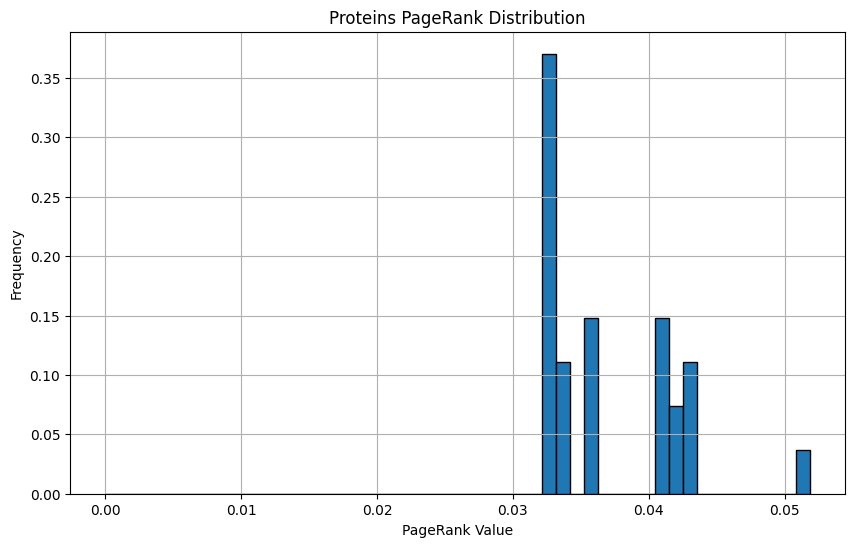

Modularity: 0.6618620037807184
Number of communities: 5
torch.Size([27, 5])
Updated data:
Data(edge_index=[2, 92], x=[27, 8], y=[1])


In [6]:
import networkx as nx
# 将边索引转换为 scipy 稀疏矩阵
import community as community_louvain  # Louvain community detection
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj, to_scipy_sparse_matrix, from_scipy_sparse_matrix
import scipy.sparse as sp
import numpy as np
import matplotlib.pyplot as plt
dataset = TUDataset(root='../tmp/Proteins', name='PROTEINS')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[1].to(device)
print(data)
def enhance_data(data):
    edge_index = data.edge_index.cpu().numpy()
    num_nodes = data.num_nodes
    G = nx.Graph()#创建networkx的空图
    for i in range(num_nodes):
        G.add_node(i, features=data.x[i].cpu().numpy())
    # 添加边
    for i, j in edge_index.T:
        G.add_edge(i, j)
    # 节点数和边数
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    print(f'Node Number: {num_nodes}')
    print(f'Edge Number: {num_edges}')
    
    density = nx.density(G)
    print(f'Graph Density: {density}')
    connected_components = list(nx.connected_components(G))
    num_connected_components = len(connected_components)
    print(f'connected_components: {num_connected_components}')
    # 节点度数和平均度数
    degree_sequence = [d for n, d in G.degree()]
    average_degree = np.mean(degree_sequence)
    print(f'Mean Degree: {average_degree}')
    # 计算 PageRank
    pagerank = nx.pagerank(G)
    pagerank_values = list(pagerank.values())

    # 计算 PageRank 的频率
    pagerank_count = np.histogram(pagerank_values, bins=50, range=(0, max(pagerank_values)))[0]
    pagerank_bins = np.histogram(pagerank_values, bins=50, range=(0, max(pagerank_values)))[1]

    # 绘制 PageRank 分布图
    plt.figure(figsize=(10, 6))
    plt.bar(pagerank_bins[:-1], pagerank_count / len(pagerank_values), width=np.diff(pagerank_bins), edgecolor='black', align='edge')
    plt.xlabel('PageRank Value')
    plt.ylabel('Frequency')
    plt.title('Proteins PageRank Distribution')
    plt.grid(True)
    plt.show()

    partition = community_louvain.best_partition(G)
    # 计算模块度
    modularity = community_louvain.modularity(partition, G)
    print(f"Modularity: {modularity}")
    # 计算社区数量
    num_communities = len(set(partition.values()))
    print(f"Number of communities: {num_communities}")
    node_embeddings = np.zeros((len(partition), num_communities))
    for node, community in partition.items():
        node_embeddings[node, community] = 1
    # 转换为 PyTorch 张量
    node_embeddings_tensor = torch.tensor(node_embeddings, dtype=torch.float)
    print(np.shape(node_embeddings_tensor))
    # 拼接原特征和独热编码特征
    original_features = data.x.cpu().numpy()  # 获取原始特征，并转换为 numpy 数组
    combined_features = np.hstack((original_features, node_embeddings))  # 拼接特征
    combined_features_tensor = torch.tensor(combined_features, dtype=torch.float).to(device)  # 转换为 PyTorch 张量
    # 更新 data 对象中的特征
    data.x = combined_features_tensor
    return data
data=enhance_data(data)
print("Updated data:")
print(data)

In [7]:
##获得数据集的data
# 将 edge_index 转换为稠密的邻接矩阵
print(data)
adj = to_dense_adj(data.edge_index)[0]
def normalize(mx):
    rowsum = np.array(mx.sum(1))  # 矩阵行求和
    r_inv = np.power(rowsum, -1).flatten()  # 每行和的-1次方
    r_inv[np.isinf(r_inv)] = 0.  # 如果是inf，转换为0
    r_mat_inv = sp.diags(r_inv)  # 转换为对角阵
    mx = r_mat_inv.dot(mx)  # D-1*A,乘上特征，按行归一化
    return mx
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)
features = sp.csr_matrix(data.x, dtype=np.float32)  # 取特征

adj = sp.coo_matrix((np.ones(data.edge_index.shape[1]), (data.edge_index[0, :], data.edge_index[1, :])),
                    shape=(data.x.shape[0], data.x.shape[0]), dtype=np.float32)

adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

features = normalize(features)  # 特征归一化
adj = normalize(adj + sp.eye(adj.shape[0]))  # A+I归一化
features = torch.FloatTensor(np.array(features.todense()))# 将numpy的数据转换成torch格式
adj = sparse_mx_to_torch_sparse_tensor(adj)

adj = adj.coalesce()

bin_adj_all = (adj.to_dense() > 0).float()
print(np.shape(bin_adj_all))

Data(edge_index=[2, 92], x=[27, 8], y=[1])
torch.Size([27, 27])


In [ ]:

model_cluster = GCNClusterNet(nfeat=50, nhid=128, nout=50, dropout=0.1, K=5, cluster_temp=50)
bin_adj_all = (adj.to_dense() > 0).float()
optimizer = torch.optim.Adam(model_cluster.parameters(), lr=0.001, weight_decay=5e-4)
test_object = make_modularity_matrix(bin_adj_all)
model_cluster.train()
num_cluster_iter = 1
losses = []

for epoch in range(2001):
    mu, r, embeds, dist = model_cluster(features, adj, num_cluster_iter)
    loss = loss_modularity(r, bin_adj_all, test_object)
    loss = -loss
    optimizer.zero_grad()
    loss.backward()
    if epoch == 100:
        num_cluster_iter = 10
    if epoch % 100 == 0:
        r = torch.softmax(100 * r, dim=1)
    loss_test = loss_modularity(r, bin_adj_all, test_object)
    if epoch == 0:
        best_train_val = 100
    if loss.item() < best_train_val:
        best_train_val = loss.item()
        curr_test_loss = loss_test.item()
        # convert distances into a feasible (fractional x)#将距离转换为可行的（分数x）
        x_best = torch.softmax(dist * 100, 0).sum(dim=1)
        x_best = 2 * (torch.sigmoid(4 * x_best) - 0.5)
        if x_best.sum() > 5:
            x_best = 5 * x_best / x_best.sum()
    losses.append(loss.item())
    optimizer.step()
    if epoch%100==0:
        print(f'epoch{epoch + 1}   ClusterNet value:{curr_test_loss}')

Average Same-Class Distance: 0.3934
Average Different-Class Distance: 1.0782


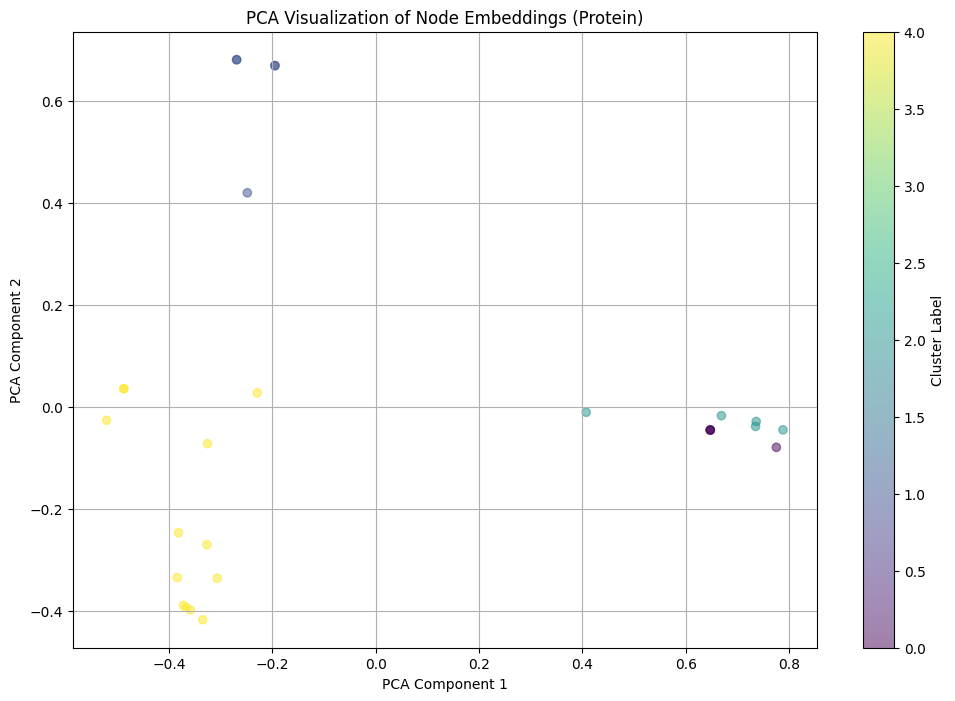

In [10]:
import numpy as np
import torch
from sklearn.decomposition import PCA
from sklearn.metrics import normalized_mutual_info_score
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

# 假设你已经训练好了模型
model_cluster.eval()  # 将模型设置为评估模式

# 获取嵌入
with torch.no_grad():
    mu, r, embeds, dist = model_cluster(features, adj)

# 将嵌入转换为 numpy 数组
embeddings_np = embeds.cpu().numpy()

# PCA 降维到二维
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings_np)

# 聚类结果（这里使用 r 的最大值索引作为聚类标签）
cluster_labels = torch.argmax(r, dim=1).cpu().numpy()



# 计算节点对之间的欧几里得距离
distances = pdist(embeddings_np, metric='euclidean')
dist_matrix = squareform(distances)

# 获取每对节点的标签
labels = np.array([cluster_labels[i] for i in range(len(cluster_labels))])

# 计算同一类别的距离和不同类别的距离
same_class_distances = []
diff_class_distances = []

for i in range(len(labels)):
    for j in range(i + 1, len(labels)):
        if labels[i] == labels[j]:
            same_class_distances.append(dist_matrix[i, j])
        else:
            diff_class_distances.append(dist_matrix[i, j])

# 计算平均距离
avg_same_class_distance = np.mean(same_class_distances) if same_class_distances else 0
avg_diff_class_distance = np.mean(diff_class_distances) if diff_class_distances else 0

print(f'Average Same-Class Distance: {avg_same_class_distance:.4f}')
print(f'Average Different-Class Distance: {avg_diff_class_distance:.4f}')

# 绘制可视化图
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.title('PCA Visualization of Node Embeddings (Protein)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True)
plt.show()

In [21]:
GCN_value=[0.6053107976913452,
 0.6618620157241821,
 0.6618620157241821,
 0.6618620157241821,
 0.6618620157241821,
 0.6618620157241821,
 0.6618620157241821,
 0.6618620157241821,
 0.6618620753288269,
 0.6618620753288269,
 0.6618620753288269,
 0.6618620753288269,
 0.6618620753288269,
 0.6618620753288269,
 0.6618620753288269,
 0.6618620753288269,
 0.6618620753288269,
 0.6618620753288269,
 0.6618620753288269,
 0.6618620753288269,
 0.6618620753288269]
Graph_Trans_value=[0.5199865698814392,
 0.6262128949165344,
 0.6618620753288269,
 0.6618617177009583,
 0.6618617177009583,
 0.6618617177009583,
 0.6618617177009583,
 0.6618617177009583,
 0.6618617177009583,
 0.6618617177009583,
 0.6618617177009583,
 0.6618617177009583,
 0.6618617177009583,
 0.6618617177009583,
 0.6618617177009583,
 0.6618617177009583,
 0.6618617177009583,
 0.6618617177009583,
 0.6618617177009583,
 0.6618617177009583,
 0.6618619561195374]
Graph_SAGE_value=[0.341446191072464,
 0.6618619561195374,
 0.6618620157241821,
 0.6618620753288269,
 0.6618620753288269,
 0.6618620753288269,
 0.6618620753288269,
 0.6618620753288269,
 0.6618620753288269,
 0.6618620753288269,
 0.6618620753288269,
 0.6618620753288269,
 0.6618620753288269,
 0.6618620753288269,
 0.6618620753288269,
 0.6618620753288269,
 0.6618620753288269,
 0.6618620753288269,
 0.6618620753288269,
 0.6618620753288269,
 0.6618620753288269]
Graph_GAT_value=[0.5645083785057068,
 0.6616771817207336,
 0.6616771817207336,
 0.6617352962493896,
 0.6617352962493896,
 0.6617352962493896,
 0.6617352962493896,
 0.6618620157241821,
 0.6618620157241821,
 0.6618620753288269,
 0.6618620753288269,
 0.6618620753288269,
 0.6618620753288269,
 0.6618620753288269,
 0.6618620753288269,
 0.6618620753288269,
 0.6618620753288269,
 0.6618620753288269,
 0.6618620753288269,
 0.6618620753288269,
 0.6618620753288269]

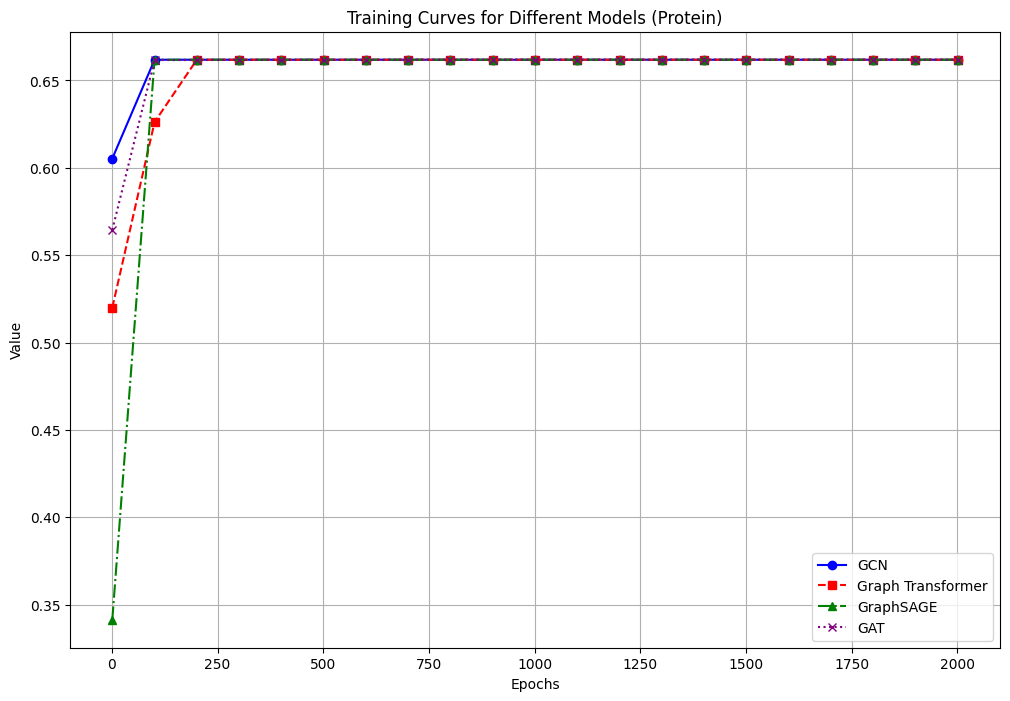

In [23]:
import matplotlib.pyplot as plt
import numpy as np# 每100个 epoch 的训练结果
epochs = np.arange(1, 2101, 100)  # 从100到2000，每100为一个间隔
# 创建图形和轴
plt.figure(figsize=(12, 8))

# 绘制每个模型的训练曲线

# 绘制每个模型的训练曲线
plt.plot(epochs, GCN_value, color='blue', linestyle='-', marker='o', label='GCN')
plt.plot(epochs, Graph_Trans_value, color='red', linestyle='--', marker='s', label='Graph Transformer')
plt.plot(epochs, Graph_SAGE_value, color='green', linestyle='-.', marker='^', label='GraphSAGE')
plt.plot(epochs, Graph_GAT_value, color='purple', linestyle=':', marker='x', label='GAT')

# 添加标签和标题
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Curves for Different Models (Protein)')
plt.legend()  # 显示图例

# 显示图形
plt.grid(True)
plt.show()